In [1]:
import xarray as xr
import pandas as pd
import numpy as np # ver = 1.22.3
import matplotlib.pyplot as plt
import netCDF4 as nc
import sys
import os
from datetime import date

## Reading in file

In [2]:
file_list = ['/home/jovyan/work/data/example_wow_minutes.nc']

for file in file_list:
    dataset = xr.load_dataset(file)
dataset

<xarray.Dataset>
Dimensions:                           (timestamp: 19680, location: 717)
Coordinates:
    lat                               (timestamp, location) float64 51.08 ......
  * location                          (location) object '23648819' ... '67c06...
    lon                               (timestamp, location) float64 6.775 ......
  * timestamp                         (timestamp) datetime64[ns] 2019-07-30 ....
Data variables: (12/13)
    AirPressure_Hectopascal           (timestamp, location) float64 nan ... nan
    DewPointTemperature_Celsius       (timestamp, location) float64 13.89 ......
    DryBulbTemperature_Celsius        (timestamp, location) float64 16.78 ......
    Height                            (timestamp, location) float64 40.0 ... nan
    MeanSeaLevelPressure_Hectopascal  (timestamp, location) float64 1.014e+03...
    RainfallAmount_Millimetre         (timestamp, location) float64 0.0 ... nan
    ...                                ...
    RelativeHumidity                  (timestamp, location) float64 83.0 ... nan
    WindDirection                     (timestamp, location) float64 180.0 ......
    WindGust_Knot                     (timestamp, location) float64 nan ... nan
    WindGust_MetrePerSecond           (timestamp, location) float64 0.7153 .....
    WindSpeed_Knot                    (timestamp, location) float64 nan ... nan
    WindSpeed_MetrePerSecond          (timestamp, location) float64 0.0 ... nan

## Variable selection and conversion to dataframe

In [3]:
test = dataset.DryBulbTemperature_Celsius.to_dataframe()
test.index

MultiIndex([('2019-07-30 00:00:00',                             '23648819'),
            ('2019-07-30 00:00:00', 'f10d15e0-76ea-e811-a140-0003ff598dc6'),
            ('2019-07-30 00:00:00',                            '923956001'),
            ('2019-07-30 00:00:00', '0cf46235-88a0-e811-b96f-0003ff597c74'),
            ('2019-07-30 00:00:00',                            '900376001'),
            ('2019-07-30 00:00:00', 'f4973f27-9c8f-e811-8c6e-0003ff597a81'),
            ('2019-07-30 00:00:00', 'a556bedb-f295-e911-80e7-0003ff59883f'),
            ('2019-07-30 00:00:00', 'd1084eec-c8b2-e911-b083-0003ff59a71f'),
            ('2019-07-30 00:00:00', '92161a88-5692-e811-b96f-0003ff597c74'),
            ('2019-07-30 00:00:00',                            '961086001'),
            ...
            ('2019-08-29 23:59:00', '9f251d3e-f2fc-e711-90cd-0003ff5993a0'),
            ('2019-08-29 23:59:00', '15f7a59b-0898-e911-80e7-0003ff59883f'),
            ('2019-08-29 23:59:00', 'a3cf2d83-7475-e911-80e7

## Fixing indexing leaving just index on timestamp

In [4]:
#test.index = pd.to_datetime(df['timestamp'])
test = test.droplevel('location')
test.index = pd.to_datetime(test.index, format = '%Y-%m-%d %H:%M:%S')#.strftime('%Y-%m-%d %H:%M:%S')

In [5]:
#x = test.groupby([test.index.strftime('%Y-%m-%d %H'),'lat','lon']).agg({'DryBulbTemperature_Celsius':['mean','min','max']})

## Grouping on lat lon and timestamp (rounded by the appropriate aggregation level)

In [6]:
x5 = test.groupby(['lat','lon',test.index.round('5min')]).agg({'DryBulbTemperature_Celsius':['mean','min','max']})

In [7]:
x10 = test.groupby(['lat','lon',test.index.round('10min')]).agg({'DryBulbTemperature_Celsius':['mean','min','max']})

In [8]:
x15 = test.groupby(['lat','lon',test.index.round('15min')]).agg({'DryBulbTemperature_Celsius':['mean','min','max']})

In [9]:
x60 = test.groupby(['lat','lon',test.index.round('H')]).agg({'DryBulbTemperature_Celsius':['mean','min','max']})

## Saving to csv (for now)

In [10]:
#x5.to_csv('/home/jovyan/work/export_test_5min.csv')

In [11]:
#x10.to_csv('/home/jovyan/work/export_test_10min.csv')

In [12]:
#x15.to_csv('/home/jovyan/work/export_test_15min.csv')

In [13]:
#x60.to_csv('/home/jovyan/work/export_test_60min.csv')

## Spatial interpolation for a specific timestamp

In [14]:
test_interpol = x60.query('timestamp==\'2019-07-30 01:00:00\'')


## Removing NAs that might confuse kriging 

In [15]:
test_interpol = test_interpol.dropna()

## Sample N stations

In [16]:
test_interpol_sample = test_interpol.sample(n=200)

In [17]:
lats=test_interpol_sample.index.get_level_values('lat')
lons=test_interpol_sample.index.get_level_values('lon')

In [18]:
len(lats)

200

In [19]:
len(lons)

200

## Defining a bounding box for NL

In [20]:
xmin=3
ymin=50.719069
xmax=7.316895
ymax=54

In [21]:
grid_lon = np.linspace(xmin, xmax, 100)
grid_lat = np.linspace(ymin, ymax, 100)

## Dowloading a shapefile for NL

**OSMnx**

Python package that lets you download geospatial data from OpenStreetMap and model, project, visualize, and analyze real-world street networks and any other geospatial geometries. You can download and model walkable, drivable, or bikeable urban networks with a single line of Python code then easily analyze and visualize them. You can just as easily download and work with other infrastructure types, amenities/points of interest, building footprints, elevation data, street bearings/orientations, and speed/travel time.

In [22]:
#import osmnx as ox
#%matplotlib inline
#ox.config(log_console=True, use_cache=True)
#ox.__version__



# from some place name, create a GeoDataFrame containing the geometry of the place
#country = ox.geocode_to_gdf('Holland, Europe')
#print (country)
# save the retrieved data as a shapefile
#country.to_file("NL_shapefile")

#using shape file provided by irene
import geopandas as gpd
NL_Boundary_Shapefile = './NL_shapefile_irene/NL_WGS84.shp'
boundary = gpd.read_file(NL_Boundary_Shapefile)



ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


## Importing libraries for kriging interpolation method

**pykrige**

The code supports 2D and 3D ordinary and universal kriging. Standard variogram models (linear, power, spherical, gaussian, exponential) are built in, but custom variogram models can also be used. The 2D universal kriging code currently supports regional-linear, point-logarithmic, and external drift terms, while the 3D universal kriging code supports a regional-linear drift term in all three spatial dimensions. Both universal kriging classes also support generic ‘specified’ and ‘functional’ drift capabilities. With the ‘specified’ drift capability, the user may manually specify the values of the drift(s) at each data point and all grid points. With the ‘functional’ drift capability, the user may provide callable function(s) of the spatial coordinates that define the drift(s). The package includes a module that contains functions that should be useful in working with ASCII grid files (\*.asc).

In [23]:
from pykrige.ok import OrdinaryKriging
from pykrige.kriging_tools import write_asc_grid
import pykrige.kriging_tools as kt

ModuleNotFoundError: No module named 'pykrige'

In [26]:
zdata = test_interpol_sample.DryBulbTemperature_Celsius

In [27]:
zdata = zdata['mean'].to_numpy()

In [28]:
zdata

array([15.61574074, 18.28888889, 17.36666667, 14.85353535, 17.19444444,
       15.34722222, 18.61111111, 16.80808081, 14.46      , 15.47777778,
       14.55555556, 17.11111111, 18.06666667, 17.96666667, 18.33333333,
       19.42      , 14.78703704, 16.76851852, 16.94444444, 15.42222222,
       18.28      , 17.44444444, 14.52020202, 18.69444444, 16.10416667,
       16.60526316, 15.43434343, 16.35555556, 17.88888889, 16.04166667,
       16.43518519, 15.87037037, 17.13425926, 17.72222222, 19.11111111,
       17.08585859, 14.44444444, 17.76851852, 16.38383838, 16.15151515,
       17.47777778, 16.59722222, 17.25      , 16.4040404 , 17.62962963,
       16.93518519, 17.2020202 , 18.83333333, 17.875     , 13.34848485,
       13.55555556, 16.81481481, 16.73148148, 17.29292929, 16.4537037 ,
       15.31818182, 17.69444444, 18.21296296, 18.81313131, 18.96296296,
       15.49074074, 16.81313131, 18.09259259, 18.80299302, 17.7037037 ,
       17.80555556, 14.31481481, 17.82828283, 15.08080808, 15.74

In [29]:
OK = OrdinaryKriging(lons, lats, zdata, variogram_model='linear', verbose=True, enable_plotting=False,nlags=20)


Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 0.29081271022519045
Nugget: 2.399229395724747 

Calculating statistics on variogram model fit...


In [30]:
z2, ss1 = OK.execute('grid', grid_lon, grid_lat)

Executing Ordinary Kriging...



## Organizing the plot

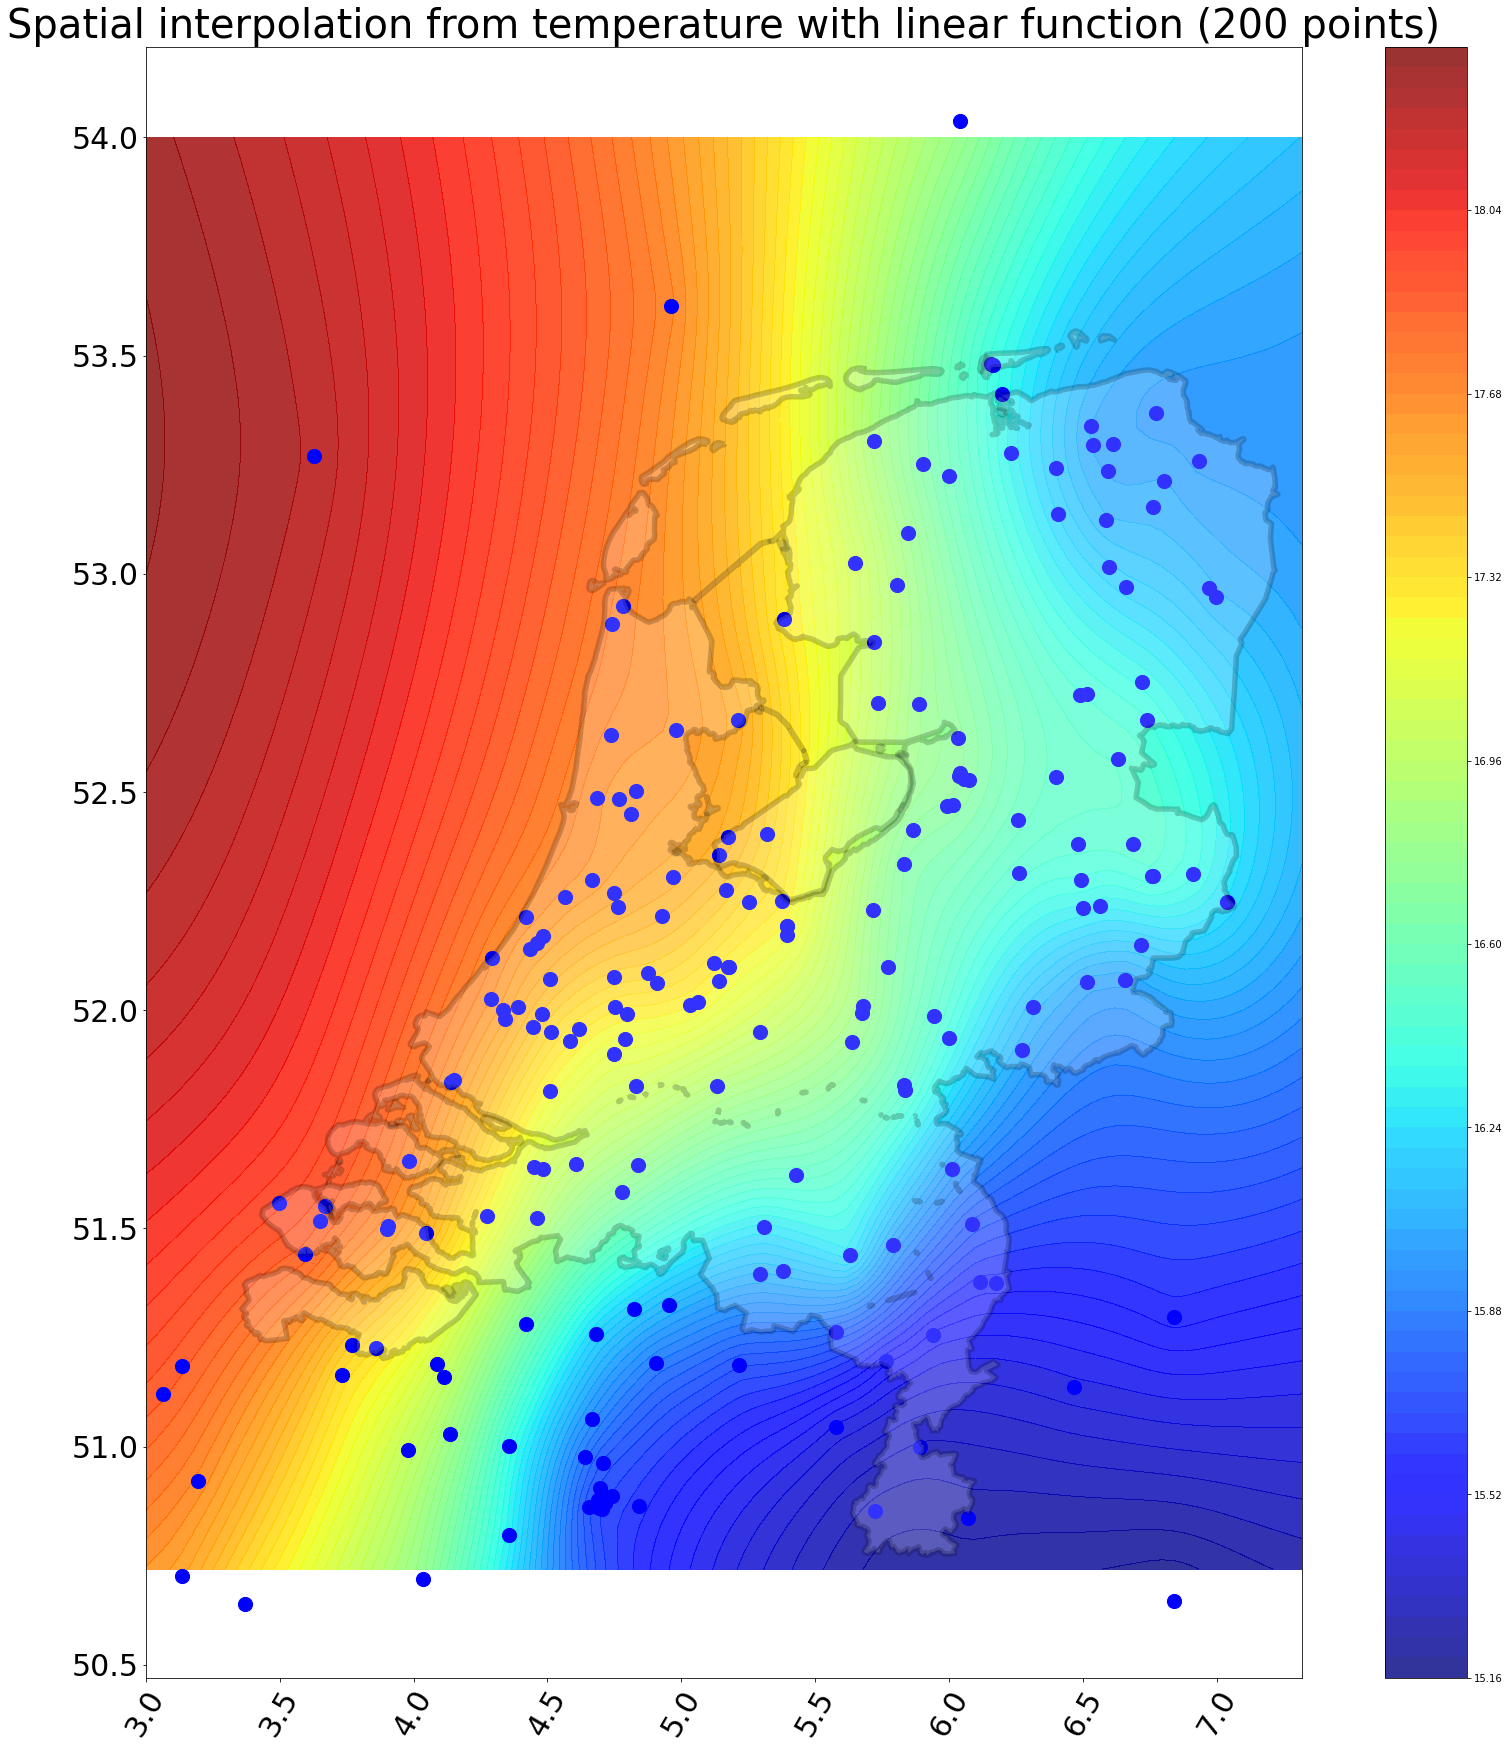

In [31]:
xintrp, yintrp = np.meshgrid(grid_lon, grid_lat) 
fig, ax = plt.subplots(figsize=(30,30))


#ax.scatter(lons, lats, s=len(lons), label='Input data')
boundarygeom = boundary.geometry

contour = plt.contourf(xintrp, yintrp, z2,len(z2),cmap=plt.cm.jet,alpha = 0.8) 


plt.colorbar(contour)


boundary.plot(ax=ax, color='white', alpha = 0.2, linewidth=5.5, edgecolor='black', zorder = 5)


npts = len(lons)

plt.scatter(lons, lats,marker='o',c='b',s=npts)

#plt.xlim(xmin,xmax)
#plt.ylim(ymin,ymax)

plt.xticks(fontsize = 30, rotation=60)
plt.yticks(fontsize = 30)

#Tempreture
plt.title('Spatial interpolation from temperature with linear function (%d points)' % npts,fontsize = 40)
plt.savefig("task1_krigng_interpol_WOW_200_points.png")
plt.show()
#ax.plot(grid_lon, grid_lat, label='Predicted values')